# A neural-network framework for modelling auditory sensory cells and synapses

Python notebook for reproducing the evaluation results of the proposed CoNNear IHC-ANF model.

## Prerequisites

- To run the full notebook for the first time, you'll have to compile the cochlea_utils.c file that is used for solving the TL model of the cochlea. This requires some C++ compiler which should be installed beforehand (more information can be found here). In a terminal, run from the Verhulstetal2018 folder:  
For Mac/Linux: ` gcc -shared -fpic -O3 -ffast-math -o tridiag.so cochlea_utils.c `  
For Windows: ` gcc -shared -fpic -O3 -ffast-math -o tridiag.dll cochlea_utils.c `

- Install numpy, scipy, keras and tensorflow

- If running on google colab: add the following as a code block and run it to compile cochlea_utils.c in the runtime machine:  
` !gcc -shared -fpic -O3 -ffast-math -o tridiag.so cochlea_utils.c `

## Import required python packages and functions
Import required python packages and define the necessary parameters.
**Notice that for all the simulations, the reference model operates at 100kHz and the CoNNear models operate at 20kHz.**

In [20]:
import scipy.signal as sp_sig
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

from Verhulstetal2018.get_tl_vbm import tl_vbm
from extra_functions import *
from time import time

# 检查版本
print('Tensorflow version: ', tf.__version__)
# 检查是否可以使用GPU
print('GPU available: ', tf.test.is_gpu_available())


Tensorflow version:  1.15.0
GPU available:  False


In [21]:
# Define model specific variables
ds_rate = 2 # downsampling rate of the frequency channels of the reference model
fs_connear = 20e3
fs_tl = 100e3
ds_factor = int(fs_tl / fs_connear)
p0 = 2e-5 # calibrate to 2e-5 Pascal
# load CFs 
CF_connear = np.loadtxt('connear/cf.txt')*1e3
# scaling values for the CoNNear models
cochlea_scaling = 1e6
ihc_scaling = 1e1
an_scaling = 1e-2
# CoNNear model directory
modeldir = 'connear/'

让我逐步解释你的代码中各个变量的含义。

### 代码解析

1. **`ds_rate = 2`**：
   - **含义**：参考模型的频率通道的下采样率。
   - **作用**：用于降低频率通道的数据采样率，提高计算效率。

2. **`fs_connear = 20e3`**：
   - **含义**：CoNNear 模型的采样率，单位是 Hz。
   - **作用**：表示在 CoNNear 模型中，每秒采样 20000 次。

3. **`fs_tl = 100e3`**：
   - **含义**：TL 模型（Transfer Learning model）的采样率，单位是 Hz。
   - **作用**：表示在 TL 模型中，每秒采样 100000 次。

4. **`ds_factor = int(fs_tl / fs_connear)`**：
   - **含义**：TL 模型采样率与 CoNNear 模型采样率的比例。
   - **作用**：计算下采样因子，用于将 TL 模型的频率通道下采样到 CoNNear 模型的频率通道。

5. **`p0 = 2e-5`**：
   - **含义**：校准值，单位为 Pascal（Pa）。
   - **作用**：用于将声压级（SPL）标准化为 2e-5 Pa，这是一个常用的参考声压值。

6. **`CF_connear = np.loadtxt('connear/cf.txt')*1e3`**：
   - **含义**：加载并转换 CF（characteristic frequency，特征频率）数据。
   - **作用**：从文件 `connear/cf.txt` 加载特征频率数据，并将其转换为 Hz（假设原始单位是 kHz）。

7. **`cochlea_scaling = 1e6`**：
   - **含义**：耳蜗模型的缩放因子。
   - **作用**：用于调整耳蜗模型的输出以匹配实际数据。

8. **`ihc_scaling = 1e1`**：
   - **含义**：内毛细胞（inner hair cell, IHC）模型的缩放因子。
   - **作用**：用于调整内毛细胞模型的输出以匹配实际数据。

9. **`an_scaling = 1e-2`**：
   - **含义**：听神经（auditory nerve, AN）模型的缩放因子。
   - **作用**：用于调整听神经模型的输出以匹配实际数据。

10. **`modeldir = 'connear/'`**：
    - **含义**：CoNNear 模型目录。
    - **作用**：指定模型文件所在的目录路径，用于加载和保存模型。

### 特征频率 (CF)
在这个上下文中，**CF**（characteristic frequency，特征频率）指的是耳蜗中各个位置响应的特定频率。这些特征频率通常表示耳蜗对不同频率声音的敏感性，反映了从基底膜不同位置记录到的频率响应特性。

总结来说，这段代码定义了模型的关键参数，并加载了一些初始数据以用于后续的模型计算和模拟。这些变量帮助配置和调整 CoNNear 模型以便更精确地模拟听觉系统的响应。

如果你有更多问题或需要进一步的解释，请告诉我！ 😊

## IHC stage
The input dimensions for the CoNNear models are (b x L x Ncf), where b is the batch-size (for loading multiple stimuli simultaneously), L is the input length (including the context) and Ncf are the frequency channels.

The ihc.json file can be loaded for the full-channel model (201 channels) or the ihc_1cf.json file for the 1-channel model. At the first block of each individual section, the necessary model is loaded and the rest of the parameters are defined.

### IHC excitation patterns
Compare the simulated average IHC receptor potentials across CF for tone stimuli presented at levels between 0 and 90 dB SPL.
**You can change the `f_tone` variable to have tone stimuli of different frequencies, say 500Hz, 1kHz, 2kHz, etc..**

In [22]:
time_elapsed=time() # measure the time elapsed for the IHC stage blocks
# Define the IHC model hyperparameters
context_left = 256
context_right = 256
Nenc = 3 # number of layers in the encoder - check for the input size
# Load the 201-channel IHC model to simulate for all CFs
N_cf = 201
ihc = load_connear_model(modeldir,json_name="/ihc.json",weights_name="/ihc.h5",name="ihc_model")
ihc.summary()

Model: "ihc_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bmm_input (InputLayer)       (None, None, 201)         0         
_________________________________________________________________
model_2 (Model)              (None, None, 201)         1317505   
Total params: 1,317,505
Trainable params: 1,317,505
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Define the pure tone stimulus
f_tone = 1e3 # frequency of the pure tone
L = np.arange(0., 91., 10.) # levels from 0 to 90dB SPL
stim_dur = 102.4e-3 # duration of the stimulus - 102.4 ms correspond to 2048 samples (fs = 20 kHz)
silence_left = 12.8e-3 # silence before the onset of the stimulus - 12.8 ms correspond to 256 samples (context)
silence_right = 12.8e-3 # silence after the stimulus - 256 samples
win_dur = 5.0e-3 # 5ms long hanning window for gradual onset

# make stimulus
t = np.arange(0., stim_dur, 1./fs_tl)
stim_sin = np.sin(2 * np.pi * f_tone * t) # generate the pure tone

# 添加白噪声
noise_level = 0.3  # 噪声水平
noise = np.random.randn(len(stim_sin)) * noise_level
stim_sin += noise

# apply hanning window
winlength = int(2*win_dur * fs_tl)
win = sp_sig.windows.hann(winlength) # double-sided hanning window
stim_sin[:int(winlength/2)] = stim_sin[:int(winlength/2)] * win[:int(winlength/2)]
stim_sin[-int(winlength/2):] = stim_sin[-int(winlength/2):] * win[int(winlength/2):]
total_length = int(silence_left * fs_tl) + len(stim_sin) + int(silence_right * fs_tl)
stim = np.zeros((len(L), total_length))
stimrange = range(int(silence_left * fs_tl), int(silence_left * fs_tl) + len(stim_sin))
for i in range(len(L)):
    stim[i, stimrange] = p0 * 10**(L[i]/20) * stim_sin / rms(stim_sin) # calibrate 

print('Done with IHC stage')

############ Verhulstetal ############
# get the outputs of the reference model 
output = tl_vbm(stim, L)

print('output shape: ', output[0]['v'].shape)

CF_tl = output[0]['cf'][::ds_rate] # center frequencies
window_length = int(total_length / ds_factor) # window length of the downsampled outputs
tl_target = np.zeros((len(L), window_length, N_cf)) # pre-allocate
ihc_target = np.zeros((len(L), window_length, N_cf))
for i in range(len(L)):
    tl_target[i,:,:] = sp_sig.resample_poly(output[i]['v'][:,::ds_rate], fs_connear, fs_tl) # cochlear output
    ihc_target[i,:,:] = sp_sig.resample_poly(output[i]['ihc'][:,::ds_rate], fs_connear, fs_tl) # IHC output
del output # remove the output variable to free-up some memory
    
# remove context from the corresponding output
ihc_target = ihc_target[:, context_left:-context_right,:]
# apply proper scaling for feeding to the CoNNear
tl_target = tl_target * cochlea_scaling # scaling for the cochlear input

# compute the mean across CF for each level
ihc_target_mean = np.mean(ihc_target,axis=1)

print('Done with Verhulstetal')

############ CoNNear #################
# check the time dimension size
if tl_target.shape[1] % 2**Nenc: # input size needs to be a multiple of 8
    Npad = int(np.ceil(tl_target.shape[1]/(2**Nenc)))*(2**Nenc)-tl_target.shape[1]
    tl_target = np.pad(tl_target,((0,0),(0,Npad),(0,0))) # zero-pad
# simulate
ihc_connear = ihc.predict(tl_target)
ihc_connear = ihc_connear / ihc_scaling # scaling for the IHC output

# compute the mean across CF for each level
ihc_connear_mean = np.mean(ihc_connear,axis=1)

print('ihc connear shape: ', ihc_connear.shape)

Done with IHC stage
running human auditory model 2018: Verhulst, Altoe, Vasilkov
cochlear simulation: done
output shape:  (12800, 401)
Done with Verhulstetal
ihc connear shape:  (10, 2048, 201)


这段代码用于定义一个纯音刺激信号，并设置一些相关的参数。下面详细介绍每个参数的作用及其意义：

### 参数解释

1. **`f_tone = 1e3`**：
   - **作用**：定义纯音的频率。
   - **意义**：`1e3` 表示 1000 Hz，也就是 1 kHz。这个频率是刺激信号的主频率，通常用于听觉实验和测试。

2. **`L = np.arange(0., 91., 10.)`**：
   - **作用**：定义刺激信号的声压级（SPL）范围。
   - **意义**：`np.arange(0., 91., 10.)` 生成从 0 dB SPL 到 90 dB SPL，步长为 10 dB 的数组。这些级别表示声音的响度，通常用于研究不同响度对听觉系统的影响。

3. **`stim_dur = 102.4e-3`**：
   - **作用**：定义刺激信号的持续时间。
   - **意义**：`102.4e-3` 表示 102.4 毫秒，这对应于在采样率为 20 kHz 的条件下，2048 个样本。这个持续时间决定了刺激信号的长度。

4. **`silence_left = 12.8e-3`**：
   - **作用**：定义刺激信号开始前的静音时间。
   - **意义**：`12.8e-3` 表示 12.8 毫秒，这对应于 256 个样本（在 20 kHz 采样率下）。这个静音时间用于提供信号的上下文，使得信号前后有间隔，以避免突变。

5. **`silence_right = 12.8e-3`**：
   - **作用**：定义刺激信号结束后的静音时间。
   - **意义**：与 `silence_left` 类似，这个参数也是 12.8 毫秒，用于信号结束后的静音间隔，以便有一个平滑的结束。

6. **`win_dur = 5.0e-3`**：
   - **作用**：定义用于信号渐进（渐强）和渐出（渐弱）的汉宁窗（Hanning window）时间。
   - **意义**：`5.0e-3` 表示 5 毫秒长的汉宁窗。汉宁窗用于信号的平滑处理，避免信号突然开始和结束，减少信号边缘的不连续性和可能的伪影。

### 总结
这些参数共同定义了一个纯音刺激信号的基本属性，包括频率、响度级别、持续时间以及信号前后和渐进渐出的时间。这些设置通常用于听觉实验和分析，以研究听觉系统对不同声音特性的反应。

希望这些解释对你有帮助！如果你有其他问题或需要进一步的解释，请告诉我。 😊

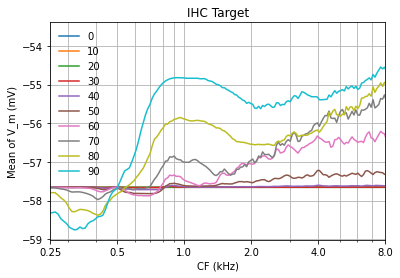

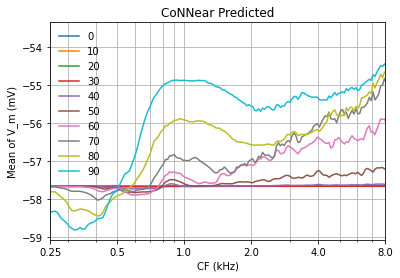

In [24]:
############ Plots ###################
# Plot the mean Vihc patterns for the reference model
CF_rep=np.tile(CF_tl, (len(L),1))
plt.semilogx(CF_rep.T/1e3, 1e3*ihc_target_mean.T)
plt.xlim(0.25,8.), plt.grid(which='both'), 
plt.xticks(ticks=(0.25, 0.5, 1., 2., 4., 8.) , labels=(0.25, 0.5, 1., 2., 4., 8.))
#plt.ylim(-59, -49.5)
plt.xlabel('CF (kHz)')
plt.ylabel('Mean of V_m (mV)')
plt.title('IHC Target')
plt.legend(L.astype(int), frameon=False)
plt.show()

# Plot the mean Vihc patterns for the CoNNear model
CF_rep=np.tile(CF_connear, (len(L),1))
plt.semilogx(CF_rep.T/1e3, 1e3*ihc_connear_mean.T)
plt.xlim(0.25,8.), plt.grid(which='both'), 
plt.xticks(ticks=(0.25, 0.5, 1., 2., 4., 8.) , labels=(0.25, 0.5, 1., 2., 4., 8.))
#plt.ylim(-59, -49.5)
plt.xlabel('CF (kHz)')
plt.ylabel('Mean of V_m (mV)')
plt.title('CoNNear Predicted')
plt.legend(L.astype(int), frameon=False)
plt.show()

del ihc # remove the connear model variable to free-up some memory

1. 使用**Verhulstetal模型**获取耳蜗的输出，这是一个仿真软件，可以获取**耳蜗的输出和IHC的输出**。
2. 把耳蜗的输出给**CoNNear模型**，获取**CoNNear模型的输出**。
3. 然后，比较**Verhulstetal模型**和**CoNNear模型**的输出，看看哪个模型更接近IHC的输出。

计算我的模型的输出和reference model输出的差异的指标.

- 均方误差 (MSE): 计算预测值与真实值之差的平方和的平均值。
- 平均绝对误差 (MAE): 计算预测值与真实值之差的绝对值的平均值。
- 均方根误差 (RMSE): 均方误差的平方根。
- R方 (R-squared): 表示模型能够解释目标变量变异的比例。

In [25]:
# print shape of output
print('ihc target mean shape: ', ihc_target_mean.shape)
print('ihc connear mean shape: ', ihc_connear_mean.shape)
print('ihc target shape: ', ihc_target.shape)
print('ihc connear shape: ', ihc_connear.shape)

# 定义函数比较mean output之间的差异
def compare_mean_output(model_output: np.ndarray, reference_output: np.ndarray)->dict:
    """
    比较两个输出之间的相似性

    Args:
        model_output: 模型输出
        reference_output: 参考输出

    Returns:
        dict: 包含多个评价指标的值
    """

    # 计算相关系数
    pearson_corr = np.corrcoef(model_output, reference_output)[0, 1]
    # 计算均方误差
    mse = np.mean((model_output - reference_output) ** 2)
    # 计算平均绝对误差
    mae = np.mean(np.abs(model_output - reference_output))

    return {
        'pearson_corr': pearson_corr,
        'mse': mse,
        'mae': mae
    }

for i in range(len(L)):
    diff = compare_mean_output(ihc_connear_mean[i], ihc_target_mean[i])
    print(f'For L={L[i]} dB SPL:')
    print(f'Pearson correlation: {diff["pearson_corr"]}')
    print(f'Mean Squared Error: {diff["mse"]}')
    print(f'Mean Absolute Error: {diff["mae"]}')
    print('---')

ihc target mean shape:  (10, 201)
ihc connear mean shape:  (10, 201)
ihc target shape:  (10, 2048, 201)
ihc connear shape:  (10, 2048, 201)
For L=0.0 dB SPL:
Pearson correlation: 0.2717028384623925
Mean Squared Error: 4.314440358536125e-12
Mean Absolute Error: 2.070639701626028e-06
---
For L=10.0 dB SPL:
Pearson correlation: 0.6669187460065154
Mean Squared Error: 3.837433012927593e-12
Mean Absolute Error: 1.953537066475888e-06
---
For L=20.0 dB SPL:
Pearson correlation: 0.4940524544572005
Mean Squared Error: 3.447216926760317e-12
Mean Absolute Error: 1.8275737850260801e-06
---
For L=30.0 dB SPL:
Pearson correlation: 0.7416781334514249
Mean Squared Error: 1.1222916053030739e-11
Mean Absolute Error: 2.300866686637218e-06
---
For L=40.0 dB SPL:
Pearson correlation: 0.9520329130917136
Mean Squared Error: 9.763966427166412e-11
Mean Absolute Error: 5.797805799895644e-06
---
For L=50.0 dB SPL:
Pearson correlation: 0.9308074548817145
Mean Squared Error: 4.868725266536323e-09
Mean Absolute Erro

### IHC AC-DC ratio
Compare the ratio of the AC and DC components of the IHC responses across CF. 

In [6]:
# Define the IHC model hyperparameters
context_left = 256
context_right = 256
Nenc = 3 # number of layers in the encoder - check for the input size
# Load the 1-channel IHC model for this section - the results are computed for individual CFs
N_cf = 1
ihc = load_connear_model(modeldir,json_name="/ihc_1cf.json",weights_name="/ihc.h5",name="ihc_model")
ihc.summary()

Model: "ihc_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bmm_input (InputLayer)       (None, None, 1)           0         
_________________________________________________________________
model_4 (Model)              (None, None, 1)           1317505   
Total params: 1,317,505
Trainable params: 1,317,505
Non-trainable params: 0
_________________________________________________________________


In [1]:
# Define the pure tone stimuli
N = 10 # number of frequencies to simulate between 0.15 and 8 kHz
f_tones = np.logspace(np.log10(150),np.log10(8000),num=N) # pick N frequencies in logarithmic spacing
# match the tone frequencies to the corresponding CFs
for j, f_tone in enumerate(f_tones):
    fno, _ = min(enumerate(CF_connear), key=lambda x: abs( x [1]- f_tone))
    f_tones[j] = CF_connear[int(fno)]
    
L = [80.] # 80 dB SPL
stim_dur = 80e-3 # duration of the stimulus
silence_left = 35.2e-3 # silence before the onset of the stimulus - 12.8 ms correspond to 256 samples (context)
silence_right = 12.8e-3 # silence after the stimulus - 256 samples
win_dur = 5.0e-3 # 5ms long ramp window for gradual onset

# indicate the time points of the response for computing the AC and DC components
t_ac_start = silence_left + 50e-3 # 50 ms after the stimulus onset
t_ac_dur = 20e-3 # 20 ms after t_ac_start
t_dc_start = 7.4e-3 # 7.4 ms after the left context (15 ms before the stimulus onset)
t_dc_dur = 10e-3 # 10 ms after t_dc_start

# region of the response for computing the AC component (50 - 70 ms after the stimulus onset)
ac_start = int(t_ac_start * fs_connear) - context_left
ac_end = ac_start + int(t_ac_dur * fs_connear)
ac_reg = np.arange(ac_start,ac_end,1)
# region of the response for computing the DC component (5 - 15 ms before the stimulus onset)
dc_start = int(t_dc_start * fs_connear)
dc_end = dc_start + int(t_dc_dur * fs_connear)
dc_reg = np.arange(dc_start,dc_end,1)

# make stimuli
t = np.arange(0., stim_dur, 1./fs_tl)
winlength = int(2*win_dur * fs_tl)
win = sp_sig.windows.bartlett(winlength) # double-sided ramp
total_length = int(silence_left * fs_tl) + len(t) + int(silence_right * fs_tl) 
stim = np.zeros((len(f_tones), total_length))
for j, f_tone in enumerate(f_tones):
    stim_sin = np.sin(2 * np.pi * f_tone * t) # generate the pure tone
    # apply ramp window
    stim_sin[:int(winlength/2)] = stim_sin[:int(winlength/2)] * win[:int(winlength/2)]
    stim_sin[-int(winlength/2):] = stim_sin[-int(winlength/2):] * win[int(winlength/2):]
    stimrange = range(int(silence_left * fs_tl), int(silence_left * fs_tl) + len(stim_sin))
    stim[j, stimrange] = p0 * 10**(L[0]/20) * stim_sin / rms(stim_sin) # calibrate 

############ Verhulstetal ############
# get the outputs of the reference model 
output = tl_vbm(stim, L)

CF_tl = output[0]['cf'][::ds_rate] # center frequencies
window_length = int(total_length / ds_factor) # window length of the downsampled outputs
tl_target = np.zeros((len(f_tones), window_length, N_cf)) # pre-allocate
ihc_target = np.zeros((len(f_tones), window_length, N_cf))
for j, f_tone in enumerate(f_tones):
    # find the CF closest to the stimulus frequency
    No, _ = min(enumerate(CF_tl), key=lambda x: abs(x[1] - f_tone))
    No = int(No)
    # extract the outputs only for the specific CF
    tl_target[j,:,:] = sp_sig.resample_poly(output[j]['v'][:,::ds_rate][:,[No]], fs_connear, fs_tl) # cochlear output
    ihc_target[j,:,:] = sp_sig.resample_poly(output[j]['ihc'][:,::ds_rate][:,[No]], fs_connear, fs_tl) # IHC output  
del output # remove the output variable to free-up some memory

# remove context from the output
ihc_target = ihc_target[:, context_left:-context_right,:]
# apply proper scaling for feeding to the CoNNear
tl_target = tl_target * cochlea_scaling # scaling for the cochlear input

# compute the AC component for each frequency
acm_target = (np.max(ihc_target[:,ac_reg],axis=1)-np.min(ihc_target[:,ac_reg],axis=1))/2 # sinusoidal amplitude
ac_target = acm_target/np.sqrt(2.) # RMS value
# compute the DC component for each frequency
dcm_target = (np.max(ihc_target[:,dc_reg],axis=1)-np.min(ihc_target[:,dc_reg],axis=1))/2
dc_target = (np.min(ihc_target[:,ac_reg],axis=1)+acm_target)-(np.min(ihc_target[:,dc_reg],axis=1)+dcm_target) # difference between the AC mean value and DC resting potential

############ CoNNear #################
# check the time dimension size
if tl_target.shape[1] % 2**Nenc: # input size needs to be a multiple of 8
    Npad = int(np.ceil(tl_target.shape[1]/(2**Nenc)))*(2**Nenc)-tl_target.shape[1]
    tl_target = np.pad(tl_target,((0,0),(0,Npad),(0,0))) # zero-pad
# simulate
ihc_connear = ihc.predict(tl_target, verbose=1)
ihc_connear = ihc_connear / ihc_scaling # scaling for the IHC output

# compute the AC component for each frequency
acm_connear = (np.max(ihc_connear[:,ac_reg],axis=1)-np.min(ihc_connear[:,ac_reg],axis=1))/2 # sinusoidal amplitude
ac_connear = acm_connear/np.sqrt(2.) # RMS value
# compute the DC component for each frequency
dcm_connear = (np.max(ihc_connear[:,dc_reg],axis=1)-np.min(ihc_connear[:,dc_reg],axis=1))/2
dc_connear = (np.min(ihc_connear[:,ac_reg],axis=1)+acm_connear)-(np.min(ihc_connear[:,dc_reg],axis=1)+dcm_connear) # difference between the AC mean value and DC resting potential

NameError: name 'np' is not defined

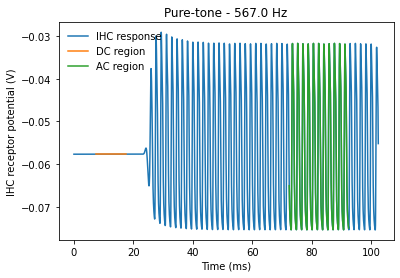

In [8]:
# Plot an example of how the AC and DC components are computed from the IHC response
fi = 500 # find the tone closest to 500 Hz

i, _ = min(enumerate(f_tones), key=lambda x: abs(x[1] - fi))
i = int(i)
t_ds = np.arange(0., ihc_target.shape[1]/fs_connear, 1./fs_connear)
np.set_printoptions(precision=3)
plt.plot(1e3*t_ds,ihc_target[i,:])
plt.plot(1e3*t_ds[dc_reg],ihc_target[i,dc_reg])
plt.plot(1e3*t_ds[ac_reg],ihc_target[i,ac_reg])
plt.xlabel('Time (ms)')
plt.ylabel('IHC receptor potential (V)')
plt.title('Pure-tone - ' + str(np.around(f_tones[i],decimals=2)) + ' Hz')
plt.legend(['IHC response','DC region','AC region'], frameon=False)
plt.show()

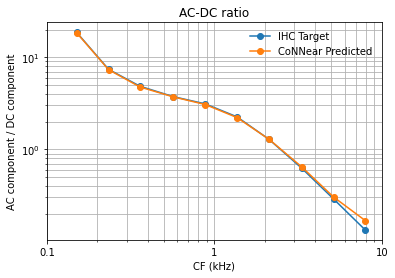

In [9]:
############ Plots ###################
# Plot the logarithmic decrease of the AC/DC ratio across frequency
plt.loglog(f_tones/1e3, ac_target/dc_target,'o-')
plt.loglog(f_tones/1e3, ac_connear/dc_connear,'o-')
plt.xlim(0.1,10.), plt.grid(which='both'), 
plt.xticks(ticks=(0.1,1,10) , labels=(0.1,1,10))
plt.xlabel('CF (kHz)')
plt.ylabel('AC component / DC component')
plt.title('AC-DC ratio')
plt.legend(['IHC Target','CoNNear Predicted'], frameon=False)
plt.show()

del ihc # remove the connear model variable to free-up some memory

### IHC level growth
Compare the growth of the half-wave rectified IHC receptor potential as a function of sound level.

在你正在使用的内毛细胞（IHC）模型中，AC 和 DC 输出分别代表交流（Alternating Current）和直流（Direct Current）成分。具体来说：

### AC 输出
- **含义**：AC（Alternating Current）成分代表信号中随时间变化的部分，主要反映快速变化的声音成分，比如振动和声音的频率变化。
- **功能**：在听觉系统中，AC 成分对应于声音的频率和时间动态特性，这部分信号能够反映出听觉系统对声音频率和调制的敏感性。
- **应用**：研究听觉系统如何响应不同频率和时间变化的声音，以及在不同声压级（SPL）下的动态特性。

### DC 输出
- **含义**：DC（Direct Current）成分代表信号中的静态成分或平均值，主要反映信号的基线水平或平均能量。
- **功能**：DC 成分对应于声音的总体强度和持续存在的特性，这部分信号能够反映出听觉系统对声音强度的平均响应。
- **应用**：研究听觉系统对不同声压级（SPL）的总体响应，以及听觉系统如何处理持续存在的声音。

### 模型的作用
通过分析 AC 和 DC 输出，模型能够提供对听觉系统动态和静态响应的全面理解。具体来说：
- **AC 输出**：可以帮助了解听觉系统对声音频率和时间变化的敏感性。
- **DC 输出**：可以帮助了解听觉系统对不同强度声音的总体响应。

In [10]:
# Define the IHC model hyperparameters
context_left = 256
context_right = 256
Nenc = 3 # number of layers in the encoder - check for the input size
# Load the 1-channel IHC model
N_cf = 1
ihc = load_connear_model(modeldir,json_name="/ihc_1cf.json",weights_name="/ihc.h5",name="ihc_model")
#ihc.summary()

In [11]:
# Define the pure tone stimuli
f_tone = 4e3 # frequency of the pure tone
# match the tone frequency to the corresponding CF
fno, _ = min(enumerate(CF_connear), key=lambda x: abs( x [1]- f_tone))
f_tone = CF_connear[int(fno)]

L = np.arange(0.,101.,10.) # levels from 0 to 100dB SPL
stim_dur = 80e-3 # duration of the stimulus
silence_left = 35.2e-3 # silence before the onset of the stimulus - 12.8 ms correspond to 256 samples (context)
silence_right = 12.8e-3 # silence after the stimulus - 256 samples
win_dur = 5.0e-3 # 5ms long ramp window for gradual onset

# make stimulus
t = np.arange(0., stim_dur, 1./fs_tl)
stim_sin = np.sin(2 * np.pi * f_tone * t) # generate the pure tone
# apply hanning window
winlength = int(2*win_dur * fs_tl)
win = sp_sig.windows.bartlett(winlength) # double-sided ramp
stim_sin[:int(winlength/2)] = stim_sin[:int(winlength/2)] * win[:int(winlength/2)]
stim_sin[-int(winlength/2):] = stim_sin[-int(winlength/2):] * win[int(winlength/2):]
total_length = int(silence_left * fs_tl) + len(stim_sin) + int(silence_right * fs_tl)
stim = np.zeros((len(L), total_length))
stimrange = range(int(silence_left * fs_tl), int(silence_left * fs_tl) + len(stim_sin))
for i in range(len(L)):
    stim[i, stimrange] = p0 * 10**(L[i]/20) * stim_sin / rms(stim_sin) # calibrate 

############ Verhulstetal ############
# get the outputs of the reference model 
output = tl_vbm(stim, L)

CF_tl = output[0]['cf'][::ds_rate] # center frequencies
# find the CF closest to the stimulus frequency
No, _ = min(enumerate(CF_tl), key=lambda x: abs(x[1] - f_tone))
No = int(No)

window_length = int(total_length / ds_factor) # window length of the downsampled outputs
tl_target = np.zeros((len(L), window_length, N_cf)) # pre-allocate
ihc_target = np.zeros((len(L), window_length, N_cf))
for i in range(len(L)):
    # extract the outputs only for the specific CF
    tl_target[i,:,:] = sp_sig.resample_poly(output[i]['v'][:,::ds_rate][:,[No]], fs_connear, fs_tl) # cochlear output
    ihc_target[i,:,:] = sp_sig.resample_poly(output[i]['ihc'][:,::ds_rate][:,[No]], fs_connear, fs_tl) # IHC output
del output # remove the output variable to free-up some memory
    
# remove context from the output
ihc_target = ihc_target[:, context_left:-context_right,:]
# apply proper scaling for feeding to the CoNNear
tl_target = tl_target * cochlea_scaling # scaling for the cochlear input

dcm_target = np.mean(ihc_target[:,dc_reg],axis=1) # compute the DC component 
vihc_target = np.zeros((ihc_target.shape))
for i in range(len(L)):
    vihc_target[i,:] = ihc_target[i,:] - dcm_target[i] #half-wave rectify the response by substracting the DC component
vihc_target_rms = rms(vihc_target,axis=1)

############ CoNNear #################
# check the time dimension size
if tl_target.shape[1] % 2**Nenc: # input size needs to be a multiple of 8
    Npad = int(np.ceil(tl_target.shape[1]/(2**Nenc)))*(2**Nenc)-tl_target.shape[1]
    tl_target = np.pad(tl_target,((0,0),(0,Npad),(0,0))) # zero-pad
# simulate
ihc_connear = ihc.predict(tl_target, verbose=1)
ihc_connear = ihc_connear / ihc_scaling # scaling for the IHC output

dcm_connear = np.mean(ihc_connear[:,dc_reg],axis=1) # compute the DC component 
vihc_connear = np.zeros((ihc_connear.shape))
for i in range(len(L)):
    vihc_connear[i,:] = ihc_connear[i,:] - dcm_connear[i] #half-wave rectify the response by substracting the DC component
vihc_connear_rms = rms(vihc_connear,axis=1)

running human auditory model 2018: Verhulst, Altoe, Vasilkov


cochlear simulation: done
11/11 [==============================] - 0s 15ms/step


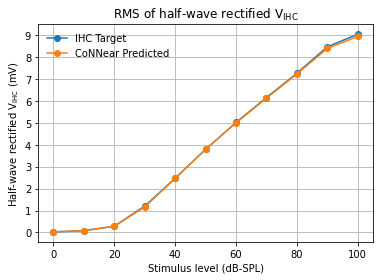

In [12]:
############ Plots ###################
# Plot the RMS of the half-wave rectified response across level
plt.plot(L, 1e3*vihc_target_rms,'o-')
plt.plot(L, 1e3*vihc_connear_rms,'o-')
plt.grid(which='both'), 
plt.yticks(ticks=np.arange(0.,10.,1.))
plt.xlabel('Stimulus level (dB-SPL)')
plt.ylabel('Half-wave rectified $\mathregular{V_{IHC}}$ (mV)')
plt.title('RMS of half-wave rectified $\mathregular{V_{IHC}}$')
plt.legend(['IHC Target','CoNNear Predicted'], frameon=False)
plt.show()

del ihc # remove the connear model variable to free-up some memory

### Speech Input
Here, a sentence from the TIMIT dataset is read from a wavfile and is used as input to the reference model and the CoNNear IHC model. The `frame_dur` parameter is used to define a shorter segment of the sentence.

In [ ]:
# # Define the IHC model hyperparameters
# context_left = 256
# context_right = 256
# Nenc = 3 # number of layers in the encoder - check for the input size
# # Load the 201-channel IHC model to simulate for all CFs
# N_cf = 201
# ihc = load_connear_model(modeldir,json_name="/ihc.json",weights_name="/ihc.h5",name="ihc_model")
# #ihc.summary()

In [ ]:
# #load the wavfile 
# wavfile = 'sx228.wav'
# L = [70.] #sound-level of 70 dB SPL
# frame_dur = 150e-3 #define segment duration
# onset_dur = 125e-3 # omit initial silence of the wavfile

# signal, fs_signal = wavfile_read(wavfile, fs_tl) # fs_tl as an argument resamples the signal to the given sampling frequency
# stim_full = np.zeros((len(L), signal.size))
# for j in range(len(L)):
#     stim_full[j,:] = p0 * 10**(L[j]/20) * signal / rms(signal) # calibrate
    
# stim_length = int(fs_tl * frame_dur + ds_factor * (context_left + context_right)) # define the segment length (including context)
# stim = stim_full[:,int(fs_tl*onset_dur):int(fs_tl*onset_dur)+stim_length] # keep the segment
# total_length = stim.shape[1]

# ############ Verhulstetal ############
# # get the outputs of the reference model 
# output = tl_vbm(stim, L)

# CF_tl = output[0]['cf'][::ds_rate] # center frequencies
# window_length = int(total_length / ds_factor) # window length of the downsampled outputs
# tl_target = np.zeros((len(L), window_length, N_cf))
# ihc_target = np.zeros((len(L), window_length, N_cf))
# for i in range(len(L)):
#     tl_target[i,:,:] = sp_sig.resample_poly(output[i]['v'][:,::ds_rate], fs_connear, fs_tl) # cochlear output
#     ihc_target[i,:,:] = sp_sig.resample_poly(output[i]['ihc'][:,::ds_rate], fs_connear, fs_tl) # IHC output
# del output # remove the output variable to free-up some memory
    
# # remove context from the output
# ihc_target = ihc_target[:, context_left:-context_right,:]
# # apply proper scaling for feeding to the CoNNear
# tl_target = tl_target * cochlea_scaling # scaling for the cochlear input

# ############ CoNNear #################
# # check the time dimension size
# if tl_target.shape[1] % 2**Nenc:# input size needs to be a multiple of 8
#     Npad = int(np.ceil(tl_target.shape[1]/(2**Nenc)))*(2**Nenc)-tl_target.shape[1]
#     tl_target = np.pad(tl_target,((0,0),(0,Npad),(0,0))) # zero-pad
# # simulate
# ihc_connear = ihc.predict(tl_target)
# ihc_connear = ihc_connear / ihc_scaling # scaling for the IHC output

running human auditory model 2018: Verhulst, Altoe, Vasilkov
cochlear simulation: done


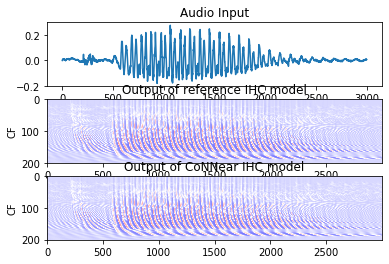

IHC stage - Time elapsed: 8.00 mins


In [ ]:
# ################ Plots ######################################
# stim=sp_sig.resample_poly(stim, fs_connear, fs_tl, axis=1)

# fig, axarr = plt.subplots(3)
# #axarr[0].set_ylim(-0.35, 0.35)
# axarr[0].plot(stim[0,context_left:-context_right].T)
# axarr[0].set_title('Audio Input')

# cax1 = axarr[1].imshow(ihc_target[0,:,:].T, cmap='bwr',aspect='auto', vmin=-0.1, vmax=0)
# axarr[1].set_title('Output of reference IHC model')
# axarr[1].set(ylabel='CF')

# cax2 = axarr[2].imshow(ihc_connear[0,:,:].T, cmap='bwr',aspect='auto', vmin=-0.1, vmax=0)  
# axarr[2].set_title('Output of CoNNear IHC model')
# axarr[2].set(ylabel='CF')

# plt.show()

# del ihc # remove the connear model variable to free-up some memory
# if 'time_elapsed' in locals() or 'time_elapsed' in globals():
#     print("IHC stage - Time elapsed: {:.{}f} mins".format((time() - time_elapsed)/60, 2 ))

## ANF stage
The input dimensions for the CoNNear models are (b x L x Ncf), where b is the batch-size (for loading multiple stimuli simultaneously), L is the input length (including the context) and Ncf are the frequency channels.

The anfX.json file can be loaded for the full-channel model (201 channels) or the anfX_1cf.json file for the 1-channel model, where X corresponds to the AN fiber type (h for HSR, m for MSR or l for LSR ANF model). At the first block of each individual section, the necessary model is loaded and the rest of the parameters are defined.

**Due to the longer size of the input stimuli, this section is computationally more expensive than the IHC stage. If you are experiencing long computation times or lags, opt for the lighter version of the notebook that loads the cochlear outputs from the CoNNear cochlea model.**

### ANF firing rates
Compare the simulated ANF firing rates across time for tone stimuli presented at 70 dB SPL.
**You can change the `f_tone` variable to have tone stimuli of different frequencies, the `f_m` variable for generating amplitude-modulated tones or the `L` variable for having different levels.**

In [ ]:
time_elapsed=time()
# Define the ANF model hyperparameters
context_left = 7936 # longer left-sided context for the ANF models
context_right = 256
Nenc = 14 # number of layers in the encoder - check for the input size
# Load the 1-channel ANF models
N_cf = 1
anfh = load_connear_model(modeldir,json_name="/anfh_1cf.json",weights_name="/anfh.h5",name="anfh_model")
anfh.summary()
anfm = load_connear_model(modeldir,json_name="/anfm_1cf.json",weights_name="/anfm.h5",name="anfm_model")
anfm.summary()
anfl = load_connear_model(modeldir,json_name="/anfl_1cf.json",weights_name="/anfl.h5",name="anfl_model")
anfl.summary()

Model: "anfh_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bmm_input (InputLayer)       (None, None, 1)           0         
_________________________________________________________________
model_3 (Model)              (None, None, 1)           1250177   
Total params: 1,250,177
Trainable params: 1,250,177
Non-trainable params: 0
_________________________________________________________________
Model: "anfm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bmm_input (InputLayer)       (None, None, 1)           0         
_________________________________________________________________
model_3 (Model)              (None, None, 1)           1250177   
Total params: 1,250,177
Trainable params: 1,250,177
Non-trainable params: 0
_________________________________________________________________
Model: "anfl_mod

In [ ]:
# Define the pure tone stimulus
f_tone = 4e3 # frequency of the pure tone
L = [70.] # stimulus level
m = 1 # modulation percentage 
f_m = 100 # modulation frequency - leave empty for pure-tone stimulus (no modulation applied)
#f_m = [] # uncomment for pure-tone stimulus

stim_dur = 400e-3 # duration of the stimulus - 409.6 ms correspond to 8192 samples (fs = 20 kHz)
silence_left = 396.8e-3 + 5e-3 # silence before the onset of the stimulus - 396.8 ms correspond to 7936 samples (left context)
silence_right = 12.8e-3 # silence after the stimulus - 256 samples (right context)
win_dur = 7.8e-3 # 5ms long ramp window for gradual onset

# match the tone frequency to the corresponding CF
fno, _ = min(enumerate(CF_connear), key=lambda x: abs( x [1]- f_tone))
f_tone = CF_connear[int(fno)]

# make stimulus
t = np.arange(0., stim_dur, 1./fs_tl)
if f_m: # if f_m is defined make a SAM tone
    stim_sin = (1 + m * np.cos(2 * np.pi * f_m * t + np.pi)) * np.sin(2 * np.pi * f_tone * t) # generate the SAM tone
else:
    stim_sin = np.sin(2 * np.pi * f_tone * t) # generate the pure tone
# apply ramp
winlength = int(2*win_dur * fs_tl)
win = sp_sig.windows.bartlett(winlength) # double-sided ramp window
stim_sin[:int(winlength/2)] = stim_sin[:int(winlength/2)] * win[:int(winlength/2)]
stim_sin[-int(winlength/2):] = stim_sin[-int(winlength/2):] * win[int(winlength/2):]
total_length = int(silence_left * fs_tl) + len(stim_sin) + int(silence_right * fs_tl)
stim = np.zeros((len(L), total_length))
stimrange = range(int(silence_left * fs_tl), int(silence_left * fs_tl) + len(stim_sin))
for i in range(len(L)):
    stim[i, stimrange] = p0 * 10**(L[i]/20) * stim_sin / rms(stim_sin) # calibrate 

############ Verhulstetal ############
# get the outputs of the reference model 
output = tl_vbm(stim, L)

CF_tl = output[0]['cf'][::ds_rate] # center frequencies
# find the CF closest to the stimulus frequency
No, _ = min(enumerate(CF_tl), key=lambda x: abs(x[1] - f_tone)) # find the CF closest to the stimulus frequency
No = int(No)

window_length = int(total_length / ds_factor) # window length of the downsampled outputs
ihc_target = np.zeros((len(L), window_length, N_cf))
anfh_target = np.zeros((len(L), window_length, N_cf))
anfm_target = np.zeros((len(L), window_length, N_cf))
anfl_target = np.zeros((len(L), window_length, N_cf))
for i in range(len(L)):
    # extract the outputs only for the specific CF
    ihc_target[i,:,:] = sp_sig.resample_poly(output[i]['ihc'][:,::ds_rate][:,[No]], fs_connear, fs_tl) # IHC output
    anfh_target[i,:,:] = output[i]['anfH'][:,::ds_rate][:,[No]] # ANF HSR output
    anfm_target[i,:,:] = output[i]['anfM'][:,::ds_rate][:,[No]] # ANF MSR output
    anfl_target[i,:,:] = output[i]['anfL'][:,::ds_rate][:,[No]] # ANF LSR output
del output # remove the output variable to free-up some memory
    
# remove context from the outputs (and the last dimension)
anfh_target = anfh_target[:, context_left:-context_right, 0]
anfm_target = anfm_target[:, context_left:-context_right, 0]
anfl_target = anfl_target[:, context_left:-context_right, 0]
# apply proper scaling for feeding to the CoNNear
ihc_target = ihc_target * ihc_scaling # scaling for the cochlear input

############ CoNNear #################
# check the time dimension size
if ihc_target.shape[1] % 2**Nenc: # input size needs to be a multiple of 16384
    Npad = int(np.ceil(ihc_target.shape[1]/(2**Nenc)))*(2**Nenc)-ihc_target.shape[1]
    ihc_target = np.pad(ihc_target,((0,0),(0,Npad),(0,0))) # zero-pad
# simulate
anfh_connear = anfh.predict(ihc_target, verbose=1)
anfm_connear = anfm.predict(ihc_target, verbose=1)
anfl_connear = anfl.predict(ihc_target, verbose=1)
# remove last dimension 
anfh_connear = anfh_connear[:, :, 0]
anfm_connear = anfm_connear[:, :, 0]
anfl_connear = anfl_connear[:, :, 0]
# scale back to the original ANF values
anfh_connear = anfh_connear / an_scaling
anfm_connear = anfm_connear / an_scaling
anfl_connear = anfl_connear / an_scaling

# crop the connear time dimensions to match the size of the reference responses
anfh_connear = anfh_connear[:,:anfh_target.shape[1]]
anfm_connear = anfm_connear[:,:anfm_target.shape[1]]
anfl_connear = anfl_connear[:,:anfl_target.shape[1]]

running human auditory model 2018: Verhulst, Altoe, Vasilkov
cochlear simulation: done
1/1 [==============================] - 1s 514ms/step


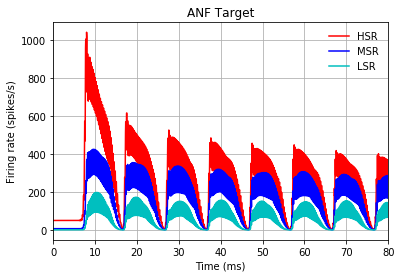

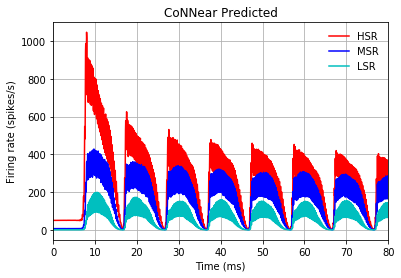

In [ ]:
############ Plots ###################
t_ds = np.arange(0., anfh_target.shape[1]/fs_connear, 1./fs_connear) # time vector of the (downsampled) responses

# Plot the firing rate patterns for the reference model
plt.plot(1e3*t_ds,anfh_target.T,'r')
plt.plot(1e3*t_ds,anfm_target.T,'b')
plt.plot(1e3*t_ds,anfl_target.T,'c')
plt.xlim(0,80.), plt.grid(which='both'), 
plt.xlabel('Time (ms)')
plt.ylabel('Firing rate (spikes/s)')
plt.title('ANF Target')
plt.legend(['HSR','MSR','LSR'], frameon=False)
plt.show()

# Plot the firing rate patterns for the CoNNear model
plt.plot(1e3*t_ds,anfh_connear.T,'r')
plt.plot(1e3*t_ds,anfm_connear.T,'b')
plt.plot(1e3*t_ds,anfl_connear.T,'c')
plt.xlim(0,80.), plt.grid(which='both'), 
plt.xlabel('Time (ms)')
plt.ylabel('Firing rate (spikes/s)')
plt.title('CoNNear Predicted')
plt.legend(['HSR','MSR','LSR'], frameon=False)
plt.show()

del anfh, anfm, anfl # remove the connear models variables to free-up some memory

### ANF rate-level curves
Compare the simulated ANF rate-level curves for the three fiber models.
**You can change the `f_tone` variable to get the curves of 1 kHz or 4 kHz.**

In [ ]:
# Define the ANF model hyperparameters
context_left = 7936
context_right = 256
Nenc = 14 # number of layers in the encoder - check for the input size
# Load the 1-channel ANF models
N_cf = 1
anfh = load_connear_model(modeldir,json_name="/anfh_1cf.json",weights_name="/anfh.h5",name="anfh_model")
#anfh.summary()
anfm = load_connear_model(modeldir,json_name="/anfm_1cf.json",weights_name="/anfm.h5",name="anfm_model")
#anfm.summary()
anfl = load_connear_model(modeldir,json_name="/anfl_1cf.json",weights_name="/anfl.h5",name="anfl_model")
#anfl.summary()

In [ ]:
# Define the pure tone stimulus
f_tone = 4e3 # frequency of the pure tone
L = np.arange(0.,101.,10.) # levels from 0 to 100 dB SPL

stim_dur = 50e-3 # duration of the stimulus - 409.6 ms correspond to 8192 samples (fs = 20 kHz)
silence_left = 396.8e-3 + 5e-3 # silence before the onset of the stimulus - 396.8 ms correspond to 7936 samples (left context)
silence_right = 12.8e-3 # silence after the stimulus - 256 samples (right context)
win_dur = 2.5e-3 # 2.5ms long ramp window for gradual onset

# match the tone frequency to the corresponding CF
fno, _ = min(enumerate(CF_connear), key=lambda x: abs( x [1]- f_tone))
f_tone = CF_connear[int(fno)]

# indicate the region of the response for computing the mean - 10-40 ms after the stimulus onset
index_start = int((silence_left + 10e-3) * fs_connear) - context_left # omit silence + 10 ms (15ms = 300 samples)
index_end = index_start + int(30e-3 * fs_connear) # keep 30 ms of response after (30ms = 600 samples)
stim_reg = np.arange(index_start,index_end,1) # stimulus region
    
# make stimulus
t = np.arange(0., stim_dur, 1./fs_tl)
stim_sin = np.sin(2 * np.pi * f_tone * t) # generate the pure tone
# apply ramp
winlength = int(2*win_dur * fs_tl)
win = sp_sig.windows.bartlett(winlength) # double-sided ramp window
stim_sin[:int(winlength/2)] = stim_sin[:int(winlength/2)] * win[:int(winlength/2)]
stim_sin[-int(winlength/2):] = stim_sin[-int(winlength/2):] * win[int(winlength/2):]
total_length = int(silence_left * fs_tl) + len(stim_sin) + int(silence_right * fs_tl)
stim = np.zeros((len(L), total_length))
stimrange = range(int(silence_left * fs_tl), int(silence_left * fs_tl) + len(stim_sin))
for i in range(len(L)):
    stim[i, stimrange] = p0 * 10**(L[i]/20) * stim_sin / rms(stim_sin) # calibrate 

############ Verhulstetal ############
# get the outputs of the reference model 
output = tl_vbm(stim, L)

CF_tl = output[0]['cf'][::ds_rate] # center frequencies
# find the CF closest to the stimulus frequency
No, _ = min(enumerate(CF_tl), key=lambda x: abs(x[1] - f_tone))
No = int(No)

window_length = int(total_length / ds_factor) # window length of the downsampled outputs
ihc_target = np.zeros((len(L), window_length, N_cf))
anfh_target = np.zeros((len(L), window_length, N_cf))
anfm_target = np.zeros((len(L), window_length, N_cf))
anfl_target = np.zeros((len(L), window_length, N_cf))
for i in range(len(L)):
    # extract the outputs only for the specific CF
    ihc_target[i,:,:] = sp_sig.resample_poly(output[i]['ihc'][:,::ds_rate][:,[No]], fs_connear, fs_tl) # IHC output
    anfh_target[i,:,:] = output[i]['anfH'][:,::ds_rate][:,[No]] # ANF HSR output
    anfm_target[i,:,:] = output[i]['anfM'][:,::ds_rate][:,[No]] # ANF MSR output
    anfl_target[i,:,:] = output[i]['anfL'][:,::ds_rate][:,[No]] # ANF LSR output
del output # remove the output variable to free-up some memory
    
# remove context from the outputs (and last dimension)
anfh_target = anfh_target[:, context_left:-context_right, 0]
anfm_target = anfm_target[:, context_left:-context_right, 0]
anfl_target = anfl_target[:, context_left:-context_right, 0]
# apply proper scaling for feeding to the CoNNear
ihc_target = ihc_target * ihc_scaling # scaling for the cochlear input

# compute the mean firing rate over the stimulus region
anfh_target_mean = np.mean(anfh_target[:,stim_reg],axis=1)
anfm_target_mean = np.mean(anfm_target[:,stim_reg],axis=1)
anfl_target_mean = np.mean(anfl_target[:,stim_reg],axis=1)

############ CoNNear #################
# check the time dimension size
if ihc_target.shape[1] % 2**Nenc: # input size needs to be a multiple of 16384
    Npad = int(np.ceil(ihc_target.shape[1]/(2**Nenc)))*(2**Nenc)-ihc_target.shape[1]
    ihc_target = np.pad(ihc_target,((0,0),(0,Npad),(0,0))) # zero-pad
# simulate
anfh_connear = anfh.predict(ihc_target, verbose=1)
anfm_connear = anfm.predict(ihc_target, verbose=1)
anfl_connear = anfl.predict(ihc_target, verbose=1)

# remove last dimension 
anfh_connear = anfh_connear[:, :, 0]
anfm_connear = anfm_connear[:, :, 0]
anfl_connear = anfl_connear[:, :, 0]
# scale back to the original ANF values
anfh_connear = anfh_connear / an_scaling
anfm_connear = anfm_connear / an_scaling
anfl_connear = anfl_connear / an_scaling

# compute the mean firing rate over the stimulus region
anfh_connear_mean = np.mean(anfh_connear[:,stim_reg],axis=1)
anfm_connear_mean = np.mean(anfm_connear[:,stim_reg],axis=1)
anfl_connear_mean = np.mean(anfl_connear[:,stim_reg],axis=1)

running human auditory model 2018: Verhulst, Altoe, Vasilkov
cochlear simulation: done
11/11 [==============================] - 1s 105ms/step


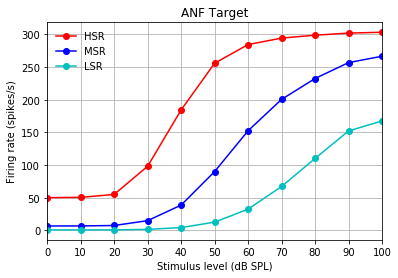

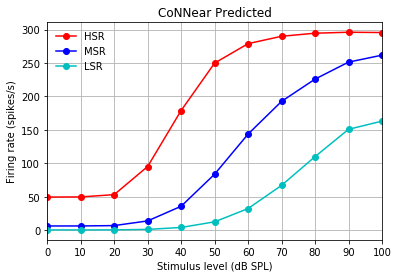

In [ ]:
############ Plots ###################
# Plot the rate-level curves for the reference model
plt.plot(anfh_target_mean.T,'ro-')
plt.plot(anfm_target_mean.T,'bo-')
plt.plot(anfl_target_mean.T,'co-')
plt.xlim(0,10), plt.grid(which='both'), 
plt.xticks(ticks=L/10 , labels=L.astype(int))
plt.xlabel('Stimulus level (dB SPL)')
plt.ylabel('Firing rate (spikes/s)')
plt.title('ANF Target')
plt.legend(['HSR','MSR','LSR'], frameon=False)
plt.show()

# Plot the rate-level curves for the CoNNear model
plt.plot(anfh_connear_mean.T,'ro-')
plt.plot(anfm_connear_mean.T,'bo-')
plt.plot(anfl_connear_mean.T,'co-')
plt.xlim(0,10), plt.grid(which='both'), 
plt.xticks(ticks=L/10 , labels=L.astype(int))
plt.xlabel('Stimulus level (dB SPL)')
plt.ylabel('Firing rate (spikes/s)')
plt.title('CoNNear Predicted')
plt.legend(['HSR','MSR','LSR'], frameon=False)
plt.show()

del anfh, anfm, anfl # remove the connear models variables to free-up some memory

### ANF synchrony-level functions
Compare the simulated ANF synchrony-level functions for the three fiber models.
**You can change the `f_tone` variable to get the curves of 1 kHz or 4 kHz.**

In [ ]:
# Define the ANF model hyperparameters
context_left = 7936
context_right = 256
Nenc = 14 # number of layers in the encoder - check for the input size
# Load the 1-channel ANF models
N_cf = 1
anfh = load_connear_model(modeldir,json_name="/anfh_1cf.json",weights_name="/anfh.h5",name="anfh_model")
#anfh.summary()
anfm = load_connear_model(modeldir,json_name="/anfm_1cf.json",weights_name="/anfm.h5",name="anfm_model")
#anfm.summary()
anfl = load_connear_model(modeldir,json_name="/anfl_1cf.json",weights_name="/anfl.h5",name="anfl_model")
#anfl.summary()

In [ ]:
# Define the pure tone stimulus
f_tone = 4e3 # frequency of the pure tone
L = np.arange(0.,101.,10.) # levels from 0 to 100 dB SPL with a step of 10 - in the paper the step is 5
f_m = 100 # modulation frequency
m = 1 # modulation percentage 

stim_dur = 400e-3 # duration of the stimulus - 409.6 ms correspond to 8192 samples (fs = 20 kHz)
silence_left = 396.8e-3 + 5e-3 # silence before the onset of the stimulus - 396.8 ms correspond to 7936 samples (left context)
silence_right = 12.8e-3 # silence after the stimulus - 256 samples (right context)
win_dur = 7.8e-3 # 7.8ms long ramp window for gradual onset

# match the tone frequency to the corresponding CF
fno, _ = min(enumerate(CF_connear), key=lambda x: abs( x [1]- f_tone))
f_tone = CF_connear[int(fno)]

# indicate the region of interest for computing the synchrony
index_start = int(silence_left * fs_connear) - context_left # omit silence (5ms = 100 samples)
index_end = index_start + int(stim_dur * fs_connear) # keep for the stimulus duration (400ms = 8000 samples)
stim_reg = np.arange(index_start,index_end,1) # stimulus region

# make stimulus
t = np.arange(0., stim_dur, 1./fs_tl)
stim_sin = (1 + m * np.cos(2 * np.pi * f_m * t + np.pi)) * np.sin(2 * np.pi * f_tone * t) # generate the SAM tone
# apply ramp
winlength = int(2*win_dur * fs_tl)
win = sp_sig.windows.bartlett(winlength) # double-sided ramp window
stim_sin[:int(winlength/2)] = stim_sin[:int(winlength/2)] * win[:int(winlength/2)]
stim_sin[-int(winlength/2):] = stim_sin[-int(winlength/2):] * win[int(winlength/2):]
total_length = int(silence_left * fs_tl) + len(stim_sin) + int(silence_right * fs_tl)
stim = np.zeros((len(L), total_length))
stimrange = range(int(silence_left * fs_tl), int(silence_left * fs_tl) + len(stim_sin))
for i in range(len(L)):
    stim[i, stimrange] = p0 * 10**(L[i]/20) * stim_sin / rms(stim_sin) # calibrate 

############ Verhulstetal ############
# get the outputs of the reference model 
output = tl_vbm(stim, L)

CF_tl = output[0]['cf'][::ds_rate] # center frequencies
# find the CF closest to the stimulus frequency
No, _ = min(enumerate(CF_tl), key=lambda x: abs(x[1] - f_tone))
No = int(No)
window_length = int(total_length / ds_factor) # window length of the downsampled outputs
ihc_target = np.zeros((len(L), window_length, N_cf))
anfh_target = np.zeros((len(L), window_length, N_cf))
anfm_target = np.zeros((len(L), window_length, N_cf))
anfl_target = np.zeros((len(L), window_length, N_cf))
for i in range(len(L)):
    # extract the outputs only for the specific CF
    ihc_target[i,:,:] = sp_sig.resample_poly(output[i]['ihc'][:,::ds_rate][:,[No]], fs_connear, fs_tl) # IHC output
    anfh_target[i,:,:] = output[i]['anfH'][:,::ds_rate][:,[No]] # ANF HSR output
    anfm_target[i,:,:] = output[i]['anfM'][:,::ds_rate][:,[No]] # ANF MSR output
    anfl_target[i,:,:] = output[i]['anfL'][:,::ds_rate][:,[No]] # ANF LSR output
del output # remove the output variable to free-up some memory

# remove context from the outputs (and last dimension)
anfh_target = anfh_target[:, context_left:-context_right, 0]
anfm_target = anfm_target[:, context_left:-context_right, 0]
anfl_target = anfl_target[:, context_left:-context_right, 0]
# apply proper scaling for feeding to the CoNNear
ihc_target = ihc_target * ihc_scaling # scaling for the ihc input

# compute the fft of the response
N = stim_reg.size
anfh_target_fft = (1/N)*(np.abs(np.fft.fft(anfh_target[:,stim_reg])))
anfm_target_fft = (1/N)*(np.abs(np.fft.fft(anfm_target[:,stim_reg])))
anfl_target_fft = (1/N)*(np.abs(np.fft.fft(anfl_target[:,stim_reg])))
# divide the modulation frequency component of the Fourier transform by the DC component (1st bin) to get the vector strengh
anfh_target_vs = anfh_target_fft[:,int(np.ceil(f_m/fs_connear*N))] / anfh_target_fft[:,0]
anfm_target_vs = anfm_target_fft[:,int(np.ceil(f_m/fs_connear*N))] / anfm_target_fft[:,0]
anfl_target_vs = anfl_target_fft[:,int(np.ceil(f_m/fs_connear*N))] / anfl_target_fft[:,0]

############ CoNNear #################
# check the time dimension size
if ihc_target.shape[1] % 2**Nenc: # input size needs to be a multiple of 16384
    Npad = int(np.ceil(ihc_target.shape[1]/(2**Nenc)))*(2**Nenc)-ihc_target.shape[1]
    ihc_target = np.pad(ihc_target,((0,0),(0,Npad),(0,0))) # zero-pad
# simulate
anfh_connear = anfh.predict(ihc_target, verbose=1)
anfm_connear = anfm.predict(ihc_target, verbose=1)
anfl_connear = anfl.predict(ihc_target, verbose=1)

# remove last dimension 
anfh_connear = anfh_connear[:, :, 0]
anfm_connear = anfm_connear[:, :, 0]
anfl_connear = anfl_connear[:, :, 0]
# scale back to the original ANF values
anfh_connear = anfh_connear / an_scaling
anfm_connear = anfm_connear / an_scaling
anfl_connear = anfl_connear / an_scaling

# compute the fft of the response
N = stim_reg.size
anfh_connear_fft = (1/N)*(np.abs(np.fft.fft(anfh_connear[:,stim_reg])))
anfm_connear_fft = (1/N)*(np.abs(np.fft.fft(anfm_connear[:,stim_reg])))
anfl_connear_fft = (1/N)*(np.abs(np.fft.fft(anfl_connear[:,stim_reg])))
# divide the modulation frequency component of the Fourier transform by the DC component (1st bin) to get the vector strengh
anfh_connear_vs = anfh_connear_fft[:,int(np.ceil(f_m/fs_connear*N))] / anfh_connear_fft[:,0]
anfm_connear_vs = anfm_connear_fft[:,int(np.ceil(f_m/fs_connear*N))] / anfm_connear_fft[:,0]
anfl_connear_vs = anfl_connear_fft[:,int(np.ceil(f_m/fs_connear*N))] / anfl_connear_fft[:,0]

running human auditory model 2018: Verhulst, Altoe, Vasilkov
cochlear simulation: done
11/11 [==============================] - 1s 115ms/step


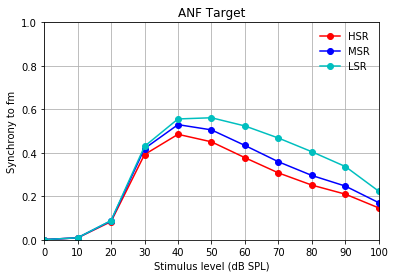

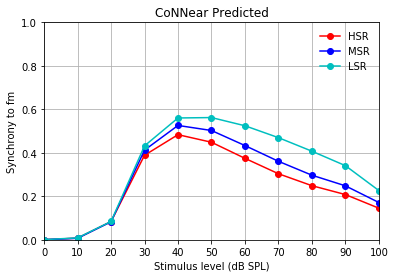

In [ ]:
############ Plots ###################
# Plot the synchrony-level functions for the reference model
plt.plot(anfh_target_vs.T,'ro-')
plt.plot(anfm_target_vs.T,'bo-')
plt.plot(anfl_target_vs.T,'co-')
plt.xlim(0,10), plt.grid(which='both'), 
plt.ylim(0,1)
plt.xticks(ticks=L/10 , labels=L.astype(int))
plt.xlabel('Stimulus level (dB SPL)')
plt.ylabel('Synchrony to fm')
plt.title('ANF Target')
plt.legend(['HSR','MSR','LSR'], frameon=False)
plt.show()

# Plot the synchrony-level functions for the CoNNear model
plt.plot(anfh_connear_vs.T,'ro-')
plt.plot(anfm_connear_vs.T,'bo-')
plt.plot(anfl_connear_vs.T,'co-')
plt.xlim(0,10), plt.grid(which='both'), 
plt.ylim(0,1)
plt.xticks(ticks=L/10 , labels=L.astype(int))
plt.xlabel('Stimulus level (dB SPL)')
plt.ylabel('Synchrony to fm')
plt.title('CoNNear Predicted')
plt.legend(['HSR','MSR','LSR'], frameon=False)
plt.show()

del anfh, anfm, anfl # remove the connear models variables to free-up some memory

### Speech Input
Here, a sentence from the TIMIT dataset is read from a wavfile and is used as input to the reference model and the CoNNear ANF models. The `frame_dur` parameter is used to define a shorter fragment of the sentence.

In [ ]:
# # Define the ANF model hyperparameters
# context_left = 7936
# context_right = 256
# Nenc = 14 # number of layers in the encoder - check for the input size
# # Load the 201-channel IHC model to simulate for all CFs
# N_cf = 201
# anfh = load_connear_model(modeldir,json_name="/anfh.json",weights_name="/anfh.h5",name="anfh_model")
# #anfh.summary()
# anfm = load_connear_model(modeldir,json_name="/anfm.json",weights_name="/anfm.h5",name="anfm_model")
# #anfm.summary()
# anfl = load_connear_model(modeldir,json_name="/anfl.json",weights_name="/anfl.h5",name="anfl_model")
# #anfl.summary()

In [ ]:
# #load the wavfile 
# wavfile = 'sx228.wav'
# L = [70.] #sound-level of 70 dB SPL
# frame_dur = 409.6e-3 #define fragment duration
# onset_dur = 125e-3 # omit initial silence of the wavfile

# signal, fs_signal = wavfile_read(wavfile, fs_tl) # fs_tl as an argument resamples the signal to the given sampling frequency
# stim_full = np.zeros((len(L), signal.size))
# for j in range(len(L)):
#     stim_full[j,:] = p0 * 10**(L[j]/20) * signal / rms(signal) # calibrate
    
# stim_length = int(fs_tl * frame_dur + ds_factor * (context_left + context_right)) # define the segment length (including context)
# stim = stim_full[:,int(fs_tl*onset_dur):int(fs_tl*onset_dur)+stim_length] # keep the segment
# total_length = stim.shape[1]

# ############ Verhulstetal ############
# # get the outputs of the reference model 
# output = tl_vbm(stim, L)

# CF_tl = output[0]['cf'][::ds_rate] # center frequencies
# window_length = int(total_length / ds_factor) # window length of the downsampled outputs
# ihc_target = np.zeros((len(L), window_length, N_cf))
# anfh_target = np.zeros((len(L), window_length, N_cf))
# anfm_target = np.zeros((len(L), window_length, N_cf))
# anfl_target = np.zeros((len(L), window_length, N_cf))
# for i in range(len(L)):
#     ihc_target[i,:,:] = sp_sig.resample_poly(output[i]['ihc'][:,::ds_rate], fs_connear, fs_tl) # IHC output
#     anfh_target[i,:,:] = output[i]['anfH'][:,::ds_rate] # ANF HSR output
#     anfm_target[i,:,:] = output[i]['anfM'][:,::ds_rate] # ANF MSR output
#     anfl_target[i,:,:] = output[i]['anfL'][:,::ds_rate] # ANF LSR output
# del output # remove the output variable to free-up some memory
    
# # remove context from the outputs
# anfh_target = anfh_target[:, context_left:-context_right, :]
# anfm_target = anfm_target[:, context_left:-context_right, :]
# anfl_target = anfl_target[:, context_left:-context_right, :]
# # apply proper scaling for feeding to the CoNNear
# ihc_target = ihc_target * ihc_scaling # scaling for the ihc input

# ############ CoNNear #################
# # check the time dimension size
# if ihc_target.shape[1] % 2**Nenc:
#     Npad = int(np.ceil(ihc_target.shape[1]/(2**Nenc)))*(2**Nenc)-ihc_target.shape[1]
#     ihc_target = np.pad(ihc_target,((0,0),(0,Npad),(0,0))) # zero-pad
# # simulate
# anfh_connear = anfh.predict(ihc_target)
# anfm_connear = anfm.predict(ihc_target)
# anfl_connear = anfl.predict(ihc_target)

# # scale back to the original ANF values
# anfh_connear = anfh_connear / an_scaling
# anfm_connear = anfm_connear / an_scaling
# anfl_connear = anfl_connear / an_scaling

running human auditory model 2018: Verhulst, Altoe, Vasilkov
cochlear simulation: done


Here, the output of the HSR ANF models is plotted. Change the `anfh_target` and `anfh_connear` variables to get the outputs of the other two fibers (i.e. `anfm_target` and `anfm_connear` or `anfl_target` and `anfl_connear`).

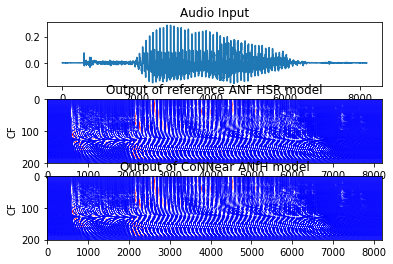

AN stage - Time elapsed: 28.03 mins


In [ ]:
# ################ Plots ######################################
# stim=sp_sig.resample_poly(stim, fs_connear, fs_tl, axis=1)

# fig, axarr = plt.subplots(3)
# #axarr[0].set_ylim(-0.35, 0.35)
# axarr[0].plot(stim[0,context_left:-context_right].T)
# axarr[0].set_title('Audio Input')

# cax1 = axarr[1].imshow(anfh_target[0,:,:].T, cmap='bwr',aspect='auto', vmin=-0, vmax=1000)
# axarr[1].set_title('Output of reference ANF HSR model')
# axarr[1].set(ylabel='CF')

# cax2 = axarr[2].imshow(anfh_connear[0,:,:].T, cmap='bwr',aspect='auto', vmin=0, vmax=1000)  
# axarr[2].set_title('Output of CoNNear ANfH model')
# axarr[2].set(ylabel='CF')

# plt.show()

# del anfh, anfm, anfl # remove the connear models variables to free-up some memory
# if 'time_elapsed' in locals() or 'time_elapsed' in globals():
#     print("AN stage - Time elapsed: {:.{}f} mins".format((time() - time_elapsed)/60, 2 ))